In [ ]:
!pip install unidecode emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 28.4 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import os
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import joblib
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class CFG:
    # --- Model and Tokenizer ---
    MODEL_NAME = 'vinai/bertweet-base'
    TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
    MAX_LEN = 128
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Training Hyperparameters (for BERT models) ---
    BATCH_SIZE = 8
    NUM_WORKERS = 0

    # --- Ensemble Configuration ---
    DRIVE_PATH = '/content/drive/My Drive/Emotion_BERT_Ensemble_Models'
    SEEDS = [101, 2468, 90210, 3141, 5555]
    MODEL_FILES = [f"model_seed_{s}.pth" for s in SEEDS]


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
# Load data
try:
    train_df = pd.read_csv("emotion-labels-train.csv")
    val_df = pd.read_csv("emotion-labels-val.csv")
    test_df = pd.read_csv("emotion-labels-test.csv")
except FileNotFoundError:
    print("Ensure 'emotion-labels-train.csv', 'emotion-labels-val.csv', and 'emotion-labels-test.csv' are in the current directory.")
    # Create dummy dataframes to avoid further errors if files are not found
    train_df = pd.DataFrame(columns=['text', 'label'])
    val_df = pd.DataFrame(columns=['text', 'label'])
    test_df = pd.DataFrame(columns=['text', 'label'])


# Preprocessing function
def pre_process_document(text):
    text = re.sub(r'<[^>]+>', ' ', text)
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = unidecode(text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

# Apply preprocessing and label encoding
train_df['text'] = train_df['text'].apply(pre_process_document)
val_df['text'] = val_df['text'].apply(pre_process_document)
test_df['text'] = test_df['text'].apply(pre_process_document)

le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
val_df['label'] = le.transform(val_df['label'])
test_df['label'] = le.transform(test_df['label'])

NUM_CLASSES = len(le.classes_)
CLASS_NAMES = le.classes_
print(f"Classes: {CLASS_NAMES}")


Classes: ['anger' 'fear' 'joy' 'sadness']


In [ ]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row.text
        label = row.label

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        self.dropout = nn.Dropout(0.3) # Using a fixed dropout for inference
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = bert_output.pooler_output
        dropped_output = self.dropout(pooled_output)
        logits = self.fc(dropped_output)
        return logits


In [ ]:
# Create datasets
train_dataset = BERTDataset(train_df, CFG.TOKENIZER, CFG.MAX_LEN)
val_dataset   = BERTDataset(val_df, CFG.TOKENIZER, CFG.MAX_LEN)
test_dataset  = BERTDataset(test_df, CFG.TOKENIZER, CFG.MAX_LEN)

def load_model(model_path):
    model = BERTClassifier(CFG.MODEL_NAME, NUM_CLASSES)
    # Load checkpoint and handle potential key mismatches
    checkpoint = torch.load(model_path, map_location=CFG.DEVICE)
    model.load_state_dict(checkpoint)
    model.to(CFG.DEVICE)
    model.eval()
    return model

# Load all BERT models from different seeds
seed_models = []
for file in CFG.MODEL_FILES:
    path = os.path.join(CFG.DRIVE_PATH, file)
    if os.path.exists(path):
        model = load_model(path)
        seed_models.append(model)
        print(f"✅ Loaded {file}")
    else:
        print(f"⚠️ Missing: {file}. Please ensure models are in the correct GDrive path.")

print(f"\nTotal models loaded: {len(seed_models)}")

def collect_logits(model, dataset):
    loader = DataLoader(dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)
    model_logits = []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(CFG.DEVICE)
            attention_mask = batch['attention_mask'].to(CFG.DEVICE)
            logits = model(input_ids, attention_mask)
            model_logits.append(logits.cpu().numpy())
    return np.concatenate(model_logits, axis=0)

# Collect logits from all models
all_train_logits, all_val_logits, all_test_logits = [], [], []
if seed_models: # Only run if models were loaded
    print(f"\nCollecting logits from {len(seed_models)} models. This may take a few minutes...")
    for i, m in enumerate(seed_models, start=1):
        print(f" -> Model {i}/{len(seed_models)}")
        all_train_logits.append(collect_logits(m, train_dataset))
        all_val_logits.append(collect_logits(m, val_dataset))
        all_test_logits.append(collect_logits(m, test_dataset))

    print("✅ Done collecting logits.")
    print(f"Shapes (per model): train {all_train_logits[0].shape}, val {all_val_logits[0].shape}, test {all_test_logits[0].shape}")
else:
    print("\nSkipping logit collection as no models were loaded.")


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

✅ Loaded model_seed_101.pth
✅ Loaded model_seed_2468.pth
✅ Loaded model_seed_90210.pth
✅ Loaded model_seed_3141.pth
✅ Loaded model_seed_5555.pth

Total models loaded: 5

 -> Model 1/5
 -> Model 2/5
 -> Model 3/5
 -> Model 4/5
 -> Model 5/5
✅ Done collecting logits.
Shapes (per model): train (3613, 4), val (347, 4), test (3142, 4)


In [ ]:
# Helper function for softmax
def softmax_np(x):
    ex = np.exp(x - np.max(x, axis=1, keepdims=True))
    return ex / np.sum(ex, axis=1, keepdims=True)

# Convert logits to probabilities and average them
if all_train_logits:
    all_train_probs = [softmax_np(l) for l in all_train_logits]
    all_val_probs   = [softmax_np(l) for l in all_val_logits]
    all_test_probs  = [softmax_np(l) for l in all_test_logits]

    # These are the features for our stacking model
    X_train = np.mean(all_train_probs, axis=0)
    X_val   = np.mean(all_val_probs, axis=0)
    X_test  = np.mean(all_test_probs, axis=0)

    # These are the labels
    y_train = train_df['label'].values
    y_val   = val_df['label'].values
    y_test  = test_df['label'].values

    print("Data prepared for XGBoost stacking.")
    print(f"X_train shape: {X_train.shape}")
else:
    print("Skipping data preparation as logits were not collected.")


Data prepared for XGBoost stacking.
X_train shape: (3613, 4)


In [ ]:
if 'X_train' in locals():
    # --- 1. Define the parameter grid for XGBoost ---
    # A smaller grid for quicker tuning. Expand this for a more exhaustive search.
    param_grid_xgb = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0]
    }

    # --- 2. GridSearchCV setup for XGBClassifier ---
    # Using the scikit-learn API for XGBoost
    xgb_classifier = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=NUM_CLASSES,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )

    grid_search_xgb = GridSearchCV(
        estimator=xgb_classifier,
        param_grid=param_grid_xgb,
        cv=5,
        scoring='accuracy',
        verbose=2,
        n_jobs=-1
    )

    print("Starting Grid Search for XGBoost hyperparameters...")
    grid_search_xgb.fit(X_train, y_train)

    print(f"\n✅ Best parameters found: {grid_search_xgb.best_params_}")
    best_xgb = grid_search_xgb.best_estimator_
else:
    print("Skipping XGBoost tuning as input data is not available.")


Starting Grid Search for XGBoost hyperparameters...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

✅ Best parameters found: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:41:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
if 'best_xgb' in locals():
    def calculate_metrics(labels, preds):
        return {
            "accuracy": accuracy_score(labels, preds),
            "f1": f1_score(labels, preds, average='weighted'),
            "precision": precision_score(labels, preds, average='weighted', zero_division=0),
            "recall": recall_score(labels, preds, average='weighted', zero_division=0)
        }

    def eval_and_return(model, X, y):
        preds = model.predict(X)
        return calculate_metrics(y, preds)

    xgb_train_metrics = eval_and_return(best_xgb, X_train, y_train)
    xgb_val_metrics   = eval_and_return(best_xgb, X_val, y_val)
    xgb_test_metrics  = eval_and_return(best_xgb, X_test, y_test)

    xgb_results = pd.DataFrame({
        'Train': xgb_train_metrics,
        'Validation': xgb_val_metrics,
        'Test': xgb_test_metrics
    }).T

    print("\n📊 Tuned Ensemble (Prob Avg) + XGBoost Stacking Performance 📊")
    display(xgb_results)
else:
    print("Skipping evaluation as the XGBoost model was not trained.")



📊 Tuned Ensemble (Prob Avg) + XGBoost Stacking Performance 📊


,accuracy,f1,precision,recall
Train,0.970938,0.970944,0.970951,0.970938
Validation,0.899135,0.899108,0.899332,0.899135
Test,0.880968,0.881202,0.881634,0.880968


In [ ]:
if 'best_xgb' in locals():
    xgb_save_path = os.path.join(CFG.DRIVE_PATH, 'Emotion_BERT_XGB_Stack_TUNED.pkl')
    # We save the model and the label encoder. No scaler was used.
    joblib.dump((best_xgb, le), xgb_save_path)
    print(f"✅ Saved TUNED XGBoost model and label encoder to: {xgb_save_path}")
else:
    print("Skipping model saving as no model was trained.")


✅ Saved TUNED XGBoost model and label encoder to: /content/drive/My Drive/Emotion_BERT_Ensemble_Models/Emotion_BERT_XGB_Stack_TUNED.pkl



📊 Confusion Matrices for Tuned XGBoost Model 📊


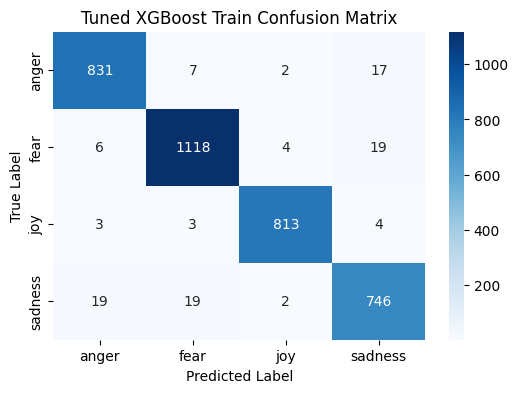

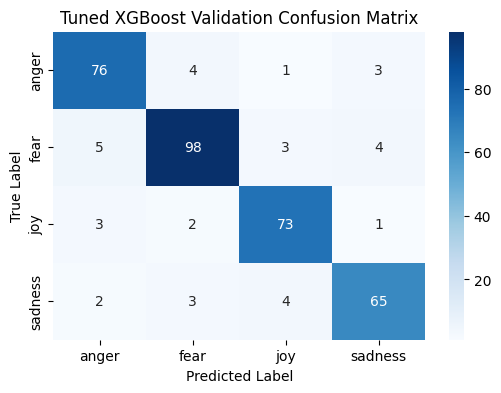

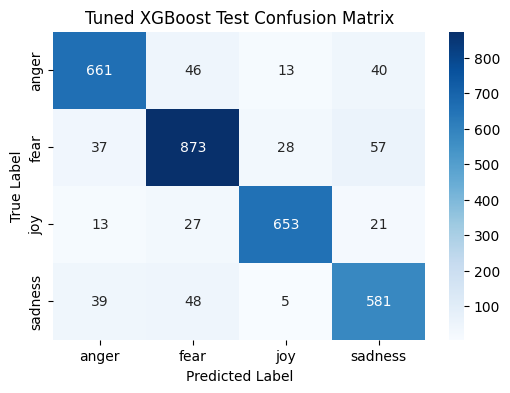

In [ ]:
if 'best_xgb' in locals():
    def plot_confusion_matrix(labels, preds, class_names, title):
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(title)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    # Get predictions from the tuned XGBoost model
    xgb_train_preds = best_xgb.predict(X_train)
    xgb_val_preds   = best_xgb.predict(X_val)
    xgb_test_preds  = best_xgb.predict(X_test)

    # Plot confusion matrices
    print("\n📊 Confusion Matrices for Tuned XGBoost Model 📊")
    plot_confusion_matrix(y_train, xgb_train_preds, CLASS_NAMES, 'Tuned XGBoost Train Confusion Matrix')
    plot_confusion_matrix(y_val, xgb_val_preds, CLASS_NAMES, 'Tuned XGBoost Validation Confusion Matrix')
    plot_confusion_matrix(y_test, xgb_test_preds, CLASS_NAMES, 'Tuned XGBoost Test Confusion Matrix')
else:
    print("Skipping confusion matrix plotting as no predictions were generated.")
